In [1]:
# DL needs
import tensorflow as tf
import keras as kr

# Data needs
import pandas as pd
from sklearn.model_selection import train_test_split

# Numerical computation needs
import numpy as np

# plotting needs
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# ensuring reproducibility
random_seed=42
tf.random.set_seed(random_seed)

import sys
sys.path.append('/home/rudraksha14/Desktop/RAY_RISE_ABOVE_YOURSELF/Programming/tensorflow/')
import important_functionalities as impf

2025-03-14 01:53:20.346824: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# load data
data_dir='/home/rudraksha14/Desktop/RAY_RISE_ABOVE_YOURSELF/Programming/tensorflow/6_transfer_learning_feature_extraction/10_food_classes_10_percent'
train_dir=data_dir+'/train'
valid_dir=data_dir+'/test'

In [3]:
IMAGE_SHAPE=(224,224)
BATCH_SIZE=32
train_data=tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                               image_size=IMAGE_SHAPE,
                                                               label_mode='categorical',
                                                                batch_size=BATCH_SIZE
                                                               )
valid_data=tf.keras.preprocessing.image_dataset_from_directory(directory=valid_dir,
                                                               image_size=IMAGE_SHAPE,
                                                                label_mode='categorical',
                                                                 batch_size=BATCH_SIZE
                                                                )

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


**2.5. Improving the baseline model, by fine tuning weights of base model**

* Number of layers to be unfrozen is an arbitary number (can be used as a hyper-param) which needs experimentation to decide.
* Usually unfreezing is done towards the top/end of the model (output layer) layers, as the initial layers of the models learn more general features (bigger shapes in the images).
* Fine tuning usually works best *after* training a feature extraction model for a few epochs with large amounts of custom data.

* Steps in fine-tuning
  * Build a feature-extraction model (training = False) 
  * Train it on the custom data
  * Unfreeze some of layers in base model, recompile the model
    * The learning rate is lowered (by how much: hyperparam, good rule of thumb is atleast 10x (though different sources claim different value)), because the layers have already learned some pattern on existing dataset, we don't want to too drastically change those patterns, as that may result in overfitting.
      * resource: ULM fit paper: https://arxiv.org/abs/1801.06146
  * Train it on custom data
  * We can keep going on in fine-tuning by unfreezing some more layers, but ensure to drop down the learning rate, with each new fine-tuning (/4).

| Experiment | Data       | Preprocessing | Model          |
|------------|------------|---------------|----------------|
| Model 3     | Same as Model 0  | Same as Model 1       | Fine-tuning: Model2(EfficientNetB0 pretrained on ImageNet) with top layer trained on custom data, top 10 layers unfrozen|

**2.5.1. Loading the checkpoints of model 2**

In [4]:
# Creating Model 2

### 1. Create data augmentation stage with horizontal flipping, rotations, zooms etc

### We can create a layer for our functional API models using Sequential API
data_augmentation=tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomWidth(0.2),
    # tf.keras.experimental.preprocessing.Rescaling(1./255)# keep for models like ResNet50V2 but EfficientNet has rescaling built-in,
],name='data_augmentation')

In [5]:
input_shape=(224,224,3)
### 2. Create the base model with tf.keras.applications
base_model=tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False,#exclude o/p layer
                                                                  weights='imagenet',
                                                                 input_shape=input_shape) 

### 3. Freeze the layers in the base model
base_model.trainable=False # keeps  model in inference mode, this also ensures batchnorm statistics don't get updated

### 4. Create inputs into our model
inputs = tf.keras.layers.Input(shape=input_shape,name='input_layer')    
print(f"Shape of inputs: {inputs.shape}")
### 5. Adding data augmentation sequential layer model as a layer
x=data_augmentation(inputs,training=True)
print(f"Shape after data_augmentation: {x.shape}") 

### 6. Pass the inputs to the base_model
x = base_model(x)
print(f"Shape after base_model: {x.shape}")

### 7. max pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name='global_max_pooling_layer')(x)
print(f"After GlobalmaxPooling2D(): {x.shape}")

### 8. Create the output activation layer
outputs = tf.keras.layers.Dense(10,activation='softmax',name='output_layer')(x)

### 9. Combine the inputs with the outputs into a model
model_2=tf.keras.Model(inputs,outputs)


### 10. Compile the model
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

### 11. Viewing model summary
model_2.summary()

Shape of inputs: (None, 224, 224, 3)
Shape after data_augmentation: (None, None, None, 3)
Shape after base_model: (None, None, None, 1280)
After GlobalmaxPooling2D(): (None, 1280)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, None, None,     │     5,919,312 │
│                                 │ 1280)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling_layer        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,932,122 (22.63 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

In [6]:
### 12. Creating a model checkpoint callback
##### set checkpoint path
checkpoint_path = "model_checkpoints/10_percent_model_checkpoints_weights/checkpoint.weights.h5"

#### create model checkpoint which saves model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq='epoch', # save every epoch
                                                         verbose=1)

In [7]:
### 13. Fit the model and save its history
initial_epochs=5
history_10_percent_model_2=model_2.fit(train_data,
                               epochs=initial_epochs,
                               steps_per_epoch=len(train_data),
                               validation_data=valid_data,
                               validation_steps=int(0.25*len(valid_data)),
                               callbacks=[impf.create_tensorboard_callback(dir_name="transfer_learning",     experiment_name="10_percent_feature_extraction_data_aug"),checkpoint_callback])

Saving TensorBoard log files to : transfer_learning/10_percent_feature_extraction_data_aug/20250314-015401
Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 776ms/step - accuracy: 0.2523 - loss: 2.1306
Epoch 1: saving model to model_checkpoints/10_percent_model_checkpoints_weights/checkpoint.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.2565 - loss: 2.1241 - val_accuracy: 0.6217 - val_loss: 1.4959
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 783ms/step - accuracy: 0.6399 - loss: 1.4753
Epoch 2: saving model to model_checkpoints/10_percent_model_checkpoints_weights/checkpoint.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.6404 - loss: 1.4722 - val_accuracy: 0.7352 - val_loss: 1.0821
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 674ms/step - accuracy: 0.7166 - loss: 1.1584
Epoch 3: saving model to model_checkpoints/10_percent_model_checkpoints_weights/checkpoint.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.7167 - loss: 1.1570 - val_accuracy: 0.7714 - val_

In [8]:
results_2_percent_data_aug=model_2.evaluate(valid_data)
results_2_percent_data_aug

79/79 ━━━━━━━━━━━━━━━━━━━━ 52s 651ms/step - accuracy: 0.8029 - loss: 0.6872


[0.6895745396614075, 0.8151999711990356]

<Figure size 640x480 with 0 Axes>

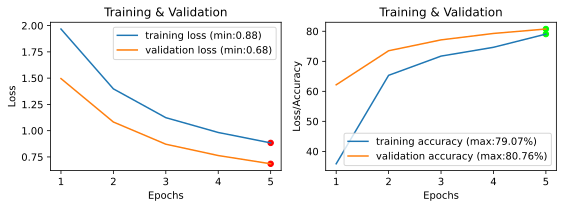

In [9]:
impf.plot_loss_curves(history_10_percent_model_2)

In [10]:
# load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [11]:
# evaluate model 2 with loaded weights
loaded_weights_model_results = model_2.evaluate(valid_data)  

79/79 ━━━━━━━━━━━━━━━━━━━━ 51s 646ms/step - accuracy: 0.8091 - loss: 0.6816


In [12]:
# layers in loaded model 2
model_2.layers

[<InputLayer name=input_layer, built=True>,
 <Sequential name=data_augmentation, built=True>,
 <Functional name=efficientnetv2-b0, built=True>,
 <GlobalAveragePooling2D name=global_max_pooling_layer, built=True>,
 <Dense name=output_layer, built=True>]

In [13]:
# Are these layers trainable
for layer in model_2.layers:
    print(f"{layer}: {layer.trainable}")

<InputLayer name=input_layer, built=True>: True
<Sequential name=data_augmentation, built=True>: True
<Functional name=efficientnetv2-b0, built=True>: False
<GlobalAveragePooling2D name=global_max_pooling_layer, built=True>: True
<Dense name=output_layer, built=True>: True


In [14]:
# what layers are in our base model (EfficientNetB0)
for i, layer in enumerate(model_2.layers[2].layers):
    print(i, layer.name, layer.trainable)

0 input_layer False
1 rescaling False
2 normalization False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [15]:
# total trainable variables in our base model
print(len(model_2.layers[2].trainable_variables))

0


In [ ]:
# fine-tuning, lets start by unfreezing the top 10 layers of our base model
base_model.trainable=True

# freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
    layer.trainable = False 

# recompile the model (model needs to be recompiled after any changes)
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # lr is 10x lower than before for fine-tuning
                metrics=['accuracy'])

In [17]:
# check which layers are tunable (trainable)
for layer_number,layer in enumerate(model_2.layers[2].layers):
    print(layer_number,layer.name,layer.trainable)

0 input_layer False
1 rescaling False
2 normalization False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [18]:
# checking the trainable parameters 
print(model_2.trainable_variables.__len__())

12


**2.5.2. Fine tuning for another 6 epochs**

In [ ]:

fine_tune_epochs = initial_epochs + 5 # model has already done 5 epochs (we're going to fine-tune for 6 more)

# refit the model (same as model_2 except with more trainable layers)
history_10_percent_model_2_fine_tuned=model_2.fit(train_data,
                                        epochs=fine_tune_epochs,
                                        steps_per_epoch=len(train_data),
                                        validation_data=valid_data,
                                        validation_steps=int(0.25*len(valid_data)),
                                        initial_epoch=history_10_percent_model_2.epoch[-1], # start from previous last epoch
                                        callbacks=[impf.create_tensorboard_callback(dir_name="transfer_learning",experiment_name="10_percent_feature_extraction_fine_tune_last_10")])

Saving TensorBoard log files to : transfer_learning/10_percent_feature_extraction_fine_tune_last_10/20250314-020039
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.7311 - loss: 1.0754 - val_accuracy: 0.8010 - val_loss: 0.7362
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.7596 - loss: 0.9390 - val_accuracy: 0.8191 - val_loss: 0.6493
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.7902 - loss: 0.8465 - val_accuracy: 0.8257 - val_loss: 0.5989
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.7595 - loss: 0.8658 - val_accuracy: 0.8306 - val_loss: 0.5625
Epoch 9/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.8236 - loss: 0.7717 - val_accuracy: 0.8306 - val_loss: 0.5407
Epoch 10/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.8050 - loss: 0.7674 - val_accuracy: 0.8405 - val_loss: 0.5098


In [22]:
loaded_weights_model_results

[0.689574658870697, 0.8151999711990356]

In [23]:
# evaluate the fine tuned model
results_fine_tuned_10_percent_data_aug = model_2.evaluate(valid_data)
results_fine_tuned_10_percent_data_aug

79/79 ━━━━━━━━━━━━━━━━━━━━ 52s 657ms/step - accuracy: 0.8361 - loss: 0.5312


[0.5403789281845093, 0.8424000144004822]

<Figure size 640x480 with 0 Axes>

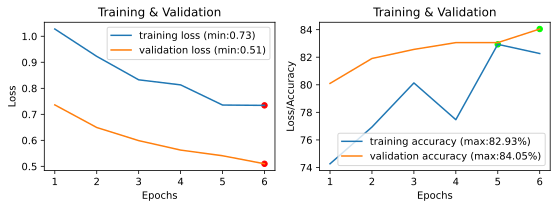

In [24]:
# plot the loss curves of fine-tuned model
impf.plot_loss_curves(history_10_percent_model_2_fine_tuned)

**2.5.3 Comparing before and after fine-tuning**

* improving `plot_loss_curves` to compare one series of running `fit()` with another (eg: before and after fine tuning)

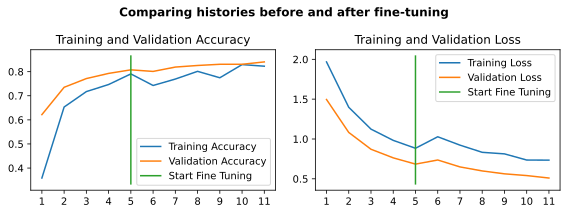

In [25]:
def compare_histories(original_history,new_history,initial_epochs=5):
    '''
    Compares two tensorflow history objects.
    '''

    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]
    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    epochs=tf.range(1,len(total_acc)+1)

    # make plots
    plt.figure(figsize=(8, 3))
    plt.subplot(1, 2, 1)
    plt.xticks(epochs)
    plt.plot(epochs,total_acc, label='Training Accuracy')  # plot total training accuracy
    plt.plot(epochs,total_val_acc, label='Validation Accuracy')  # plot total validation accuracy
    plt.plot([initial_epochs, initial_epochs],
              plt.ylim(), label='Start Fine Tuning')  # create a line to show end of transfer learning
    plt.legend(loc="lower right")
    plt.title('Training and Validation Accuracy')

    # plt.figure(figsize=(4, 8))
    plt.subplot(1, 2, 2)
    plt.xticks(epochs)
    plt.plot(epochs,total_loss, label='Training Loss')  # plot total training loss
    plt.plot(epochs,total_val_loss, label='Validation Loss')  # plot total validation loss
    plt.plot([initial_epochs, initial_epochs],
              plt.ylim(), label='Start Fine Tuning')  # create a line to show end of transfer learning
    plt.legend(loc="upper right")
    plt.title('Training and Validation Loss')
    plt.suptitle('Comparing histories before and after fine-tuning',fontweight='bold')
    plt.tight_layout()
    plt.show()



compare_histories(history_10_percent_model_2,history_10_percent_model_2_fine_tuned,initial_epochs=5)

***-- CONTD IN NEXT NOTEBOOK --***